In [16]:
# Importing modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from typing import Tuple
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed) 

In [8]:
# Load dataset once
imdb_dataset = load_dataset("imdb")

In [9]:
# Preprocess the data
def preprocess(text):
    return text.lower().split()

train_sentences = [preprocess(text) for text in imdb_dataset['train']['text']]
test_sentences = [preprocess(text) for text in imdb_dataset['test']['text']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Vectorize the sentences
def vectorize_sentences(sentences, model, vector_size):
    vectors = []
    for sentence in sentences:
        sentence_vec = np.zeros(vector_size)
        for word in sentence:
            if word in model.wv:
                sentence_vec += model.wv[word]
        vectors.append(sentence_vec / len(sentence))
    return np.array(vectors)

X_train = vectorize_sentences(train_sentences, w2v_model, 100)
X_test = vectorize_sentences(test_sentences, w2v_model, 100)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Inspect the shape of the transformed data
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Train data shape: (25000, 100)
Test data shape: (25000, 100)


In [10]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Extract labels
y_train = imdb_dataset['train']['label']
y_test = imdb_dataset['test']['label']

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

# Initialize the Logistic Regression model
classifier = LogisticRegression()

grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)  # X_train and y_train need to be predefined with your data

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'C': 0.1, 'max_iter': 100, 'solver': 'saga'}
Best cross-validation score: 0.77


In [11]:
# Fit the model on the training data
classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7712


In [21]:
# Now we try with the best params available via gridsearch

optimized_classifier = LogisticRegression(**grid_search.best_params_) # dict unpacked

optimized_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_optimized = optimized_classifier.predict(X_test)

# Calculate the accuracy
accuracy_optimized = accuracy_score(y_test, y_pred)

print(f"Grid Search Accuracy: {accuracy:.4f}")

Grid Search Accuracy: 0.7712


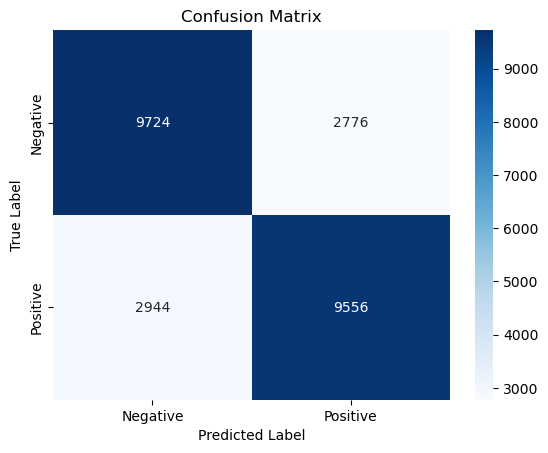

In [22]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot using seaborn for better visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

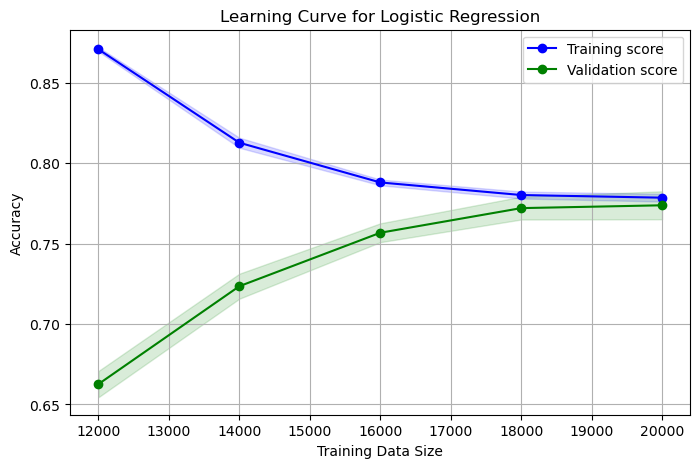

In [19]:
# Generate the training set sizes and learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=classifier,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # Use all computer cores
)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for validation set scores
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)

plt.plot(train_sizes, validation_mean, label='Validation score', color='green', marker='o')
plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.15)

plt.title('Learning Curve for Logistic Regression')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')  # Ensure this line is present to show the legend
plt.grid(True)
plt.show()